# Black Scholes Model Deep Calibration

Kurzer Versuch....

In [55]:
# Libraries laden
import numpy as np
from math import log, sqrt, exp
from scipy import stats
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [56]:
# Function that equals R's expand_grid
import itertools
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [57]:
# Generate sznthetic data
synthetic_data = expand_grid({
    'stock_price': np.arange(40, 61),
    'strike_price':np.arange(20, 90),
    'maturity': np.arange(3/12, 2, step = 1/12),
    'risk_free_rate':np.arange(0.01, 0.06, step = 0.01),
    'sigma': np.arange(0.1, 0.9, step = 0.1)
}
)

In [58]:
# Black-Scholes Modell zur Berechnung der IV
def bs_option_value(S0, K, T, r, sigma):
    'Function to calculate the value of a call option based on the Black-Scholes formula'
    'arguments:'
    'S0: inital stock price'
    'K: strike price'
    'T: maturity'
    'r: risk free rate (constant)'
    'sigma: volatility'
    'returns: option value'
    #calculate d1 and d2
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    d2 = ((np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    option_value = S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0)
    return option_value

In [59]:
# Testing the function
bs_option_value(1,2,4,3,5)

0.9999999988919036

In [60]:
# calculate option vega
def option_vega(S0, K, T, r, sigma):
    'takes the same arguments as the function above'
    'returns option vega'
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T)))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

In [61]:
# Testing the function
option_vega(1,2,3,4,5)

1.7320507924724615

In [62]:
# calculate implied volatility
def implied_volatility(S0, K, T, C0, r, sigma):
    'calculates the implied volatility'
    'C0: call price'
    'retunts implied volatility'
    d1 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0) - C0
    
    vega = (1 / np.sqrt(2 * np.pi)) * S0 * np.sqrt(T) * np.exp(-(stats.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    # Warum hier andere Formal fuer vega?
    
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while (abs(xnew - xold) > tolerance):
        xold = xnew
        xnew = (xnew - fx - C0) / vega
        
        return abs(xnew)
# Quelle fuer vega und iv : https://aaronschlegel.me/implied-volatility-functions-python.html

In [63]:
# Testing the function
implied_volatility(1,2,3,4,5,6)

8.683118302572918

In [64]:
implied_volatility_call(4, 1,2,3,5,6)

found on 0th iteration
difference is equal to -3.0000006118046407


In [65]:
synthetic_data['black_scholes'] = bs_option_value(synthetic_data['stock_price'], synthetic_data['strike_price'],
                                               synthetic_data['maturity'], synthetic_data['risk_free_rate'],
                                               synthetic_data['sigma'])

In [66]:
# Add some random noise to the real prices to create the option prices
synthetic_data["option_price"] = synthetic_data["black_scholes"] + np.random.normal(1, 0.1)

In [67]:
# subset of the data for code testing
#synthetic_data = synthetic_data.loc[1:100000]

In [68]:
# Calculate implied volatility (the variable of interest; used later in the neural network)
synthetic_data['imp_vol'] = synthetic_data.apply(lambda row: implied_volatility(row['option_price'], row['stock_price'], row['strike_price'],
                                              row['maturity'], row['risk_free_rate'], row['sigma']), axis = 1)

In [70]:
synthetic_data.tail()

,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price,imp_vol
1234795,60,89,1.916667,0.05,0.4,7.034793,7.952471,0.012613
1234796,60,89,1.916667,0.05,0.5,10.297248,11.214925,0.002305
1234797,60,89,1.916667,0.05,0.6,13.608121,14.525799,0.008225
1234798,60,89,1.916667,0.05,0.7,16.897179,17.814857,0.009812
1234799,60,89,1.916667,0.05,0.8,20.122101,21.039779,0.009988


In [71]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(synthetic_data, test_size = 0.01,
                                                   random_state = 42)

In [74]:
train

,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price,imp_vol
483303,48,35,0.833333,0.03,0.8,19.819627,20.737305,0.015531
992823,56,81,1.833333,0.03,0.8,18.013249,18.930926,0.011704
523674,48,83,0.916667,0.05,0.3,0.286426,1.204103,0.057100
456675,47,73,1.333333,0.05,0.4,3.047691,3.965368,0.012132
160003,42,70,1.083333,0.01,0.4,1.238989,2.156666,0.079867
...,...,...,...,...,...,...,...,...
110268,41,81,0.666667,0.04,0.5,0.528234,1.445912,0.096671
259178,44,48,1.166667,0.03,0.3,4.713893,5.631570,0.047447
131932,42,37,0.333333,0.02,0.5,7.612169,8.529846,0.044095
671155,51,48,1.916667,0.05,0.4,14.410194,15.327872,0.034037


In [72]:
# Daten standardisieren
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [19]:
def standardize(train, test, cols):
    
    # Pruefen, ob korrekt spaltenweise standardisiert wurde - > passt
    cols = cols
    
    scaler = StandardScaler().fit(train[cols])
    train_std=pd.DataFrame(scaler.transform(train[cols]), columns = cols)

    test_std=pd.DataFrame(scaler.transform(test[cols]), columns = cols)
    return train_std, test_std

In [111]:
columns = ["stock_price", 'strike_price', 'maturity', 'risk_free_rate', 'sigma', 'option_price', 'imp_vol']
train_std, test_std = standardize(train, test, columns)

In [112]:
#All variables now have 0 mean and std.dev 1
train_std.describe()

,stock_price,strike_price,maturity,risk_free_rate,sigma,option_price,imp_vol
count,1.222452e+06,1.222452e+06,1.222452e+06,1.222452e+06,1.222452e+06,1.222452e+06,1.222452e+06
mean,1.297920e-15,-1.399374e-16,-1.112979e-15,-2.103291e-15,1.401682e-15,-1.215458e-15,2.933637e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.651488e+00,-1.707533e+00,-1.651447e+00,-1.414344e+00,-1.527611e+00,-1.157175e+00,-1.007729e+00
25%,-8.257595e-01,-8.661821e-01,-8.257010e-01,-7.072452e-01,-6.547270e-01,-8.881225e-01,-6.299780e-01
50%,-3.134175e-05,2.466045e-02,4.512230e-05,-1.463419e-04,2.181567e-01,-2.134170e-01,-3.051944e-01
75%,8.256968e-01,8.660118e-01,8.257912e-01,7.069525e-01,1.091040e+00,6.910842e-01,3.269166e-01
max,1.651425e+00,1.707363e+00,1.651537e+00,1.414051e+00,1.527482e+00,3.264956e+00,9.081711e+00


In [114]:
# Dataframes with Xs and ys
X_train = train_std.drop(['option_price', 'imp_vol'], axis = 1)
X_test = test_std.drop(['option_price', 'imp_vol'], axis = 1)
y_train = train['imp_vol']
y_test = test['imp_vol']

In [115]:
X_train

,stock_price,strike_price,maturity,risk_free_rate,sigma
0,-0.330323,-0.965165,-0.495403,-0.000146,1.527482
1,0.990842,1.311433,1.486388,-0.000146,1.527482
2,-0.330323,1.410416,-0.330253,1.414051,-0.654727
3,-0.495468,0.915503,0.495493,1.414051,-0.218285
4,-1.321196,0.767029,0.000045,-1.414344,-0.218285
...,...,...,...,...,...
1222447,-1.486342,1.311433,-0.825701,0.706952,0.218157
1222448,-0.990905,-0.321778,0.165194,-0.000146,-0.654727
1222449,-1.321196,-0.866182,-1.486298,-0.707245,0.218157
1222450,0.165114,-0.321778,1.651537,1.414051,-0.218285


In [239]:
# Netz bauen, noch kein finetuning
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = (5,)), # Anzahl Features
    tf.keras.layers.Dense(units = 1000, activation = 'elu'),
    tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 800, activation = 'elu'),
    tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 600, activation = 'elu'),
    tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 200, activation = 'elu'),
    tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 10, activation = 'elu')
])
model.compile(loss='mse',optimizer='adam')
# Model configuration: Liu et al. (2019)

In [240]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 1000)              6000      
_________________________________________________________________
dropout_16 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 800)               800800    
_________________________________________________________________
dropout_17 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 600)               480600    
_________________________________________________________________
dropout_18 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 200)              

In [92]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=4) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs. model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)]) 
#model.compile(tf.keras.optimizers.SGD(), loss='mse') 
#history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5), 
                  #  epochs=10, batch_size=1, callbacks=[callback], 
                   # verbose=0) 
#len(history.history['loss'])  # Only 4 epochs are run.

#tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                min_delta=0, 
#                                patience=0, 
#                                verbose=0, 
#                                mode='auto', 
#                                baseline=None, 
#                                restore_best_weights=False)

# https://blog.paperspace.com/tensorflow-callbacks/

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size = 1024, epochs = 1000, verbose = 1, callbacks = [callback])


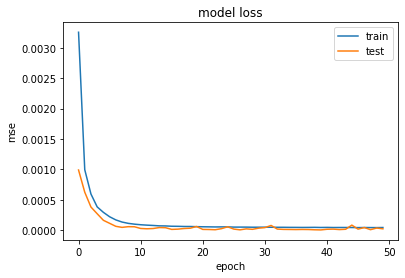

In [183]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [184]:
y_hat = model.predict(X_test)
y_hat = np.squeeze(y_hat)

In [185]:
y_hat

array([0.01912218, 0.02738454, 0.02759041, ..., 0.01464678, 0.06020879,
       0.00859156], dtype=float32)

In [27]:
weights_1 = model.layers[0].weights
weights_2 = model.layers[2].weights
weights_3 = model.layers[4].weights
weights_4 = model.layers[6].weights
weights_5 = model.layers[8].weights

In [ ]:
weights_5

In [ ]:
# Backward Model

In [120]:
def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = np.sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = np.sqrt(stats['mse'])/np.mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual IV',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted IV',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    return stats

Mean Squared Error:       2.347772345346657e-05
Root Mean Squared Error:  0.004845381662311708
Mean Absolute Error:      0.003367936214741003
Mean Percent Error:       0.1249299100507829


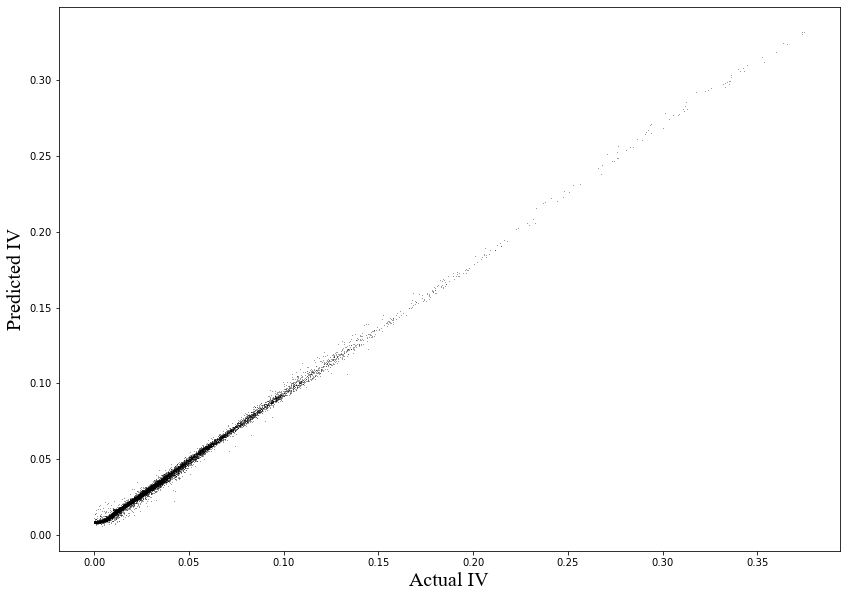

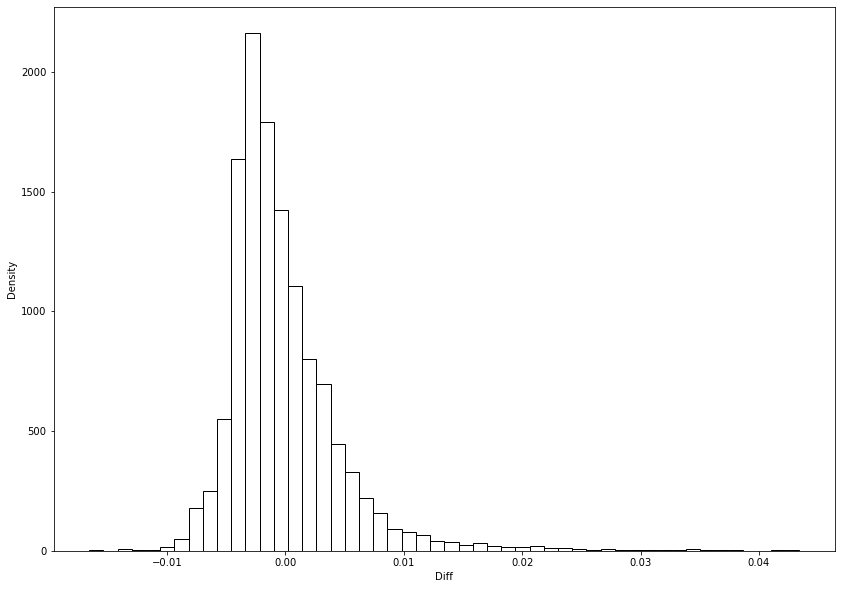

{'diff': 954765    -0.003610
 711377    -0.001055
 1086810   -0.001370
 859684    -0.001629
 1040050    0.003451
              ...   
 530703    -0.003210
 608920    -0.004227
 591292    -0.002741
 462411     0.002638
 1120191   -0.006095
 Name: imp_vol, Length: 12348, dtype: float64,
 'mse': 2.347772345346657e-05,
 'rmse': 0.004845381662311708,
 'mae': 0.003367936214741003,
 'mpe': 0.1249299100507829}

In [186]:
CheckAccuracy(y_test,y_hat)

In [194]:
# plot df
plot_df = X_test.drop(['risk_free_rate', 'sigma'], axis = 1)

In [196]:
plot_df['moneyness'] = plot_df['stock_price'] - plot_df['strike_price']
plot_df['pred_iv'] = y_hat
plot_df['imp_vol'] = y_test.tolist()

In [206]:
plot_df['mae'] = abs(plot_df['imp_vol'] - plot_df['pred_iv'])

In [207]:
plot_df

,stock_price,strike_price,maturity,moneyness,pred_iv,imp_vol,mae
0,0.990842,-0.915673,0.495493,1.906516,0.019122,0.015512,0.003610
1,0.330260,-1.410586,1.321239,1.740846,0.027385,0.026330,0.001055
2,1.321134,-0.074322,1.156090,1.395456,0.027590,0.026220,0.001370
3,0.660551,0.420590,-0.165104,0.239961,0.027945,0.026315,0.001629
4,1.155988,0.668047,-1.155999,0.487941,0.070048,0.073499,0.003451
...,...,...,...,...,...,...,...
12343,-0.165177,-1.658042,0.990940,1.492865,0.012192,0.008982,0.003210
12344,-0.000031,-0.519743,1.486388,0.519712,0.017971,0.013743,0.004227
12345,-0.000031,-1.559060,1.486388,1.559028,0.014647,0.011906,0.002741
12346,-0.495468,1.261942,0.000045,-1.757410,0.060209,0.062847,0.002638


C:\Users\Jonas\AppData\Local\Temp\ipykernel_14876\1369060011.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


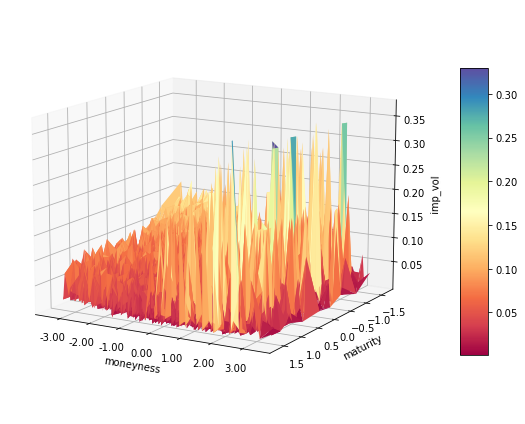

In [229]:
plot_iv_surface(plot_df, z = 'imp_vol')

C:\Users\Jonas\AppData\Local\Temp\ipykernel_14876\1369060011.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


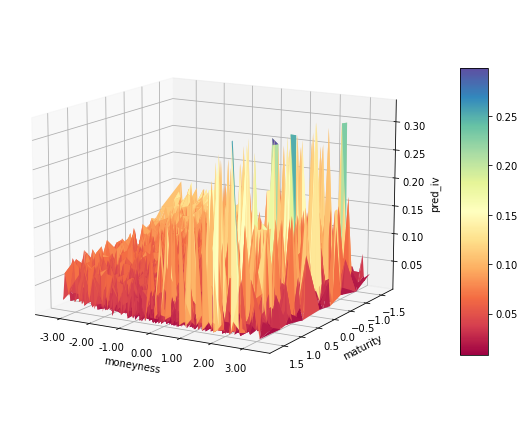

In [230]:
plot_iv_surface(plot_df, z = 'pred_iv')

In [209]:
df = pd.DataFrame(plot_df, columns = ['moneyness', 'mae'])

<AxesSubplot:>

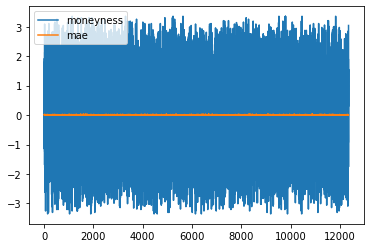

In [212]:
df.plot()

AttributeError: 'Line2D' object has no property 'type'

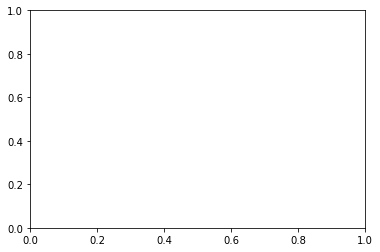

In [213]:
import matplotlib.pyplot as plt
df.plot(x = 'moneyness', y = 'mae', type = 'scatter')
plt.show()

In [214]:
# Generate iv
stock_price = np.linspace(40, 60, 21)
strike_price = np.linspace(20,90, 21)
maturity = np.linspace(3/12, 2, 18)

stock_price, strike_price, maturity = np.meshgrid(stock_price, strike_price, maturity)

df_iv = pd.DataFrame(columns=train.columns)
df_iv['stock_price'] = stock_price.flatten()
df_iv['strike_price'] = strike_price.flatten()
df_iv['maturity'] = maturity.flatten()
df_iv['risk_free_rate'] = 0.01
df_iv['sigma'] = 0.1

In [215]:
df_iv

,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price,imp_vol
0,40.0,20.0,0.250000,0.01,0.1,NaN,NaN,NaN
1,40.0,20.0,0.352941,0.01,0.1,NaN,NaN,NaN
2,40.0,20.0,0.455882,0.01,0.1,NaN,NaN,NaN
3,40.0,20.0,0.558824,0.01,0.1,NaN,NaN,NaN
4,40.0,20.0,0.661765,0.01,0.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
7933,60.0,90.0,1.588235,0.01,0.1,NaN,NaN,NaN
7934,60.0,90.0,1.691176,0.01,0.1,NaN,NaN,NaN
7935,60.0,90.0,1.794118,0.01,0.1,NaN,NaN,NaN
7936,60.0,90.0,1.897059,0.01,0.1,NaN,NaN,NaN


In [216]:
df_iv['black_scholes'] = bs_option_value(df_iv['stock_price'], df_iv['strike_price'],
                                               df_iv['maturity'], df_iv['risk_free_rate'],
                                               df_iv['sigma'])

In [217]:
# Add some random noise to the real prices to create the option prices
df_iv["option_price"] = df_iv["black_scholes"] + np.random.normal(1, 0.1)

In [218]:
df_iv['imp_vol'] = df_iv.apply(lambda row: implied_volatility(row['option_price'], row['stock_price'], row['strike_price'],
                                              row['maturity'], row['risk_free_rate'], row['sigma']), axis = 1)

In [219]:
df_iv_2 = df_iv.drop(['black_scholes', 'option_price', 'imp_vol'], axis = 1)

In [220]:
columns = ["stock_price", 'strike_price', 'maturity', 'risk_free_rate', 'sigma']
df_iv_scaled, df_iv_scaled_2 = standardize(df_iv, df_iv, columns)

In [221]:
df_iv_scaled

,stock_price,strike_price,maturity,risk_free_rate,sigma
0,-1.651446,-1.651446,-1.638356,0.0,-1.387779e-17
1,-1.651446,-1.651446,-1.445608,0.0,-1.387779e-17
2,-1.651446,-1.651446,-1.252861,0.0,-1.387779e-17
3,-1.651446,-1.651446,-1.060113,0.0,-1.387779e-17
4,-1.651446,-1.651446,-0.867365,0.0,-1.387779e-17
...,...,...,...,...,...
7933,1.651446,1.651446,0.867365,0.0,-1.387779e-17
7934,1.651446,1.651446,1.060113,0.0,-1.387779e-17
7935,1.651446,1.651446,1.252861,0.0,-1.387779e-17
7936,1.651446,1.651446,1.445608,0.0,-1.387779e-17


In [222]:
df_iv['iv_pred'] = model.predict(df_iv_scaled)

In [233]:
df_iv['moneyness'] = df_iv['strike_price'] / df_iv['stock_price']

In [224]:
df_iv['mae'] = abs(df_iv['imp_vol'] - df_iv['iv_pred'])

In [236]:
X_train.shape

(1222452, 5)

In [234]:
df_iv

,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price,imp_vol,iv_pred,moneyness,mae
0,40.0,20.0,0.250000,0.01,0.1,20.049938,20.962543,0.037890,0.022119,0.5,0.015770
1,40.0,20.0,0.352941,0.01,0.1,20.070464,20.983069,0.037924,0.020721,0.5,0.017203
2,40.0,20.0,0.455882,0.01,0.1,20.090969,21.003574,0.037958,0.019609,0.5,0.018350
3,40.0,20.0,0.558824,0.01,0.1,20.111453,21.024058,0.037992,0.018613,0.5,0.019380
4,40.0,20.0,0.661765,0.01,0.1,20.131916,21.044521,0.038026,0.017685,0.5,0.020341
...,...,...,...,...,...,...,...,...,...,...,...
7933,60.0,90.0,1.588235,0.01,0.1,0.002529,0.915135,0.029154,0.017547,1.5,0.011607
7934,60.0,90.0,1.691176,0.01,0.1,0.003773,0.916378,0.029117,0.016904,1.5,0.012213
7935,60.0,90.0,1.794118,0.01,0.1,0.005399,0.918005,0.029067,0.016341,1.5,0.012727
7936,60.0,90.0,1.897059,0.01,0.1,0.007461,0.920066,0.029005,0.015836,1.5,0.013169


In [226]:
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

def plot_iv_surface(data, x="moneyness", y='maturity', z='iv'):
    """ Plots the IV surface
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.gca(projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap = plt.cm.Spectral)
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    plt.tight_layout()
    
    plt.show()

C:\Users\Jonas\AppData\Local\Temp\ipykernel_14876\1369060011.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


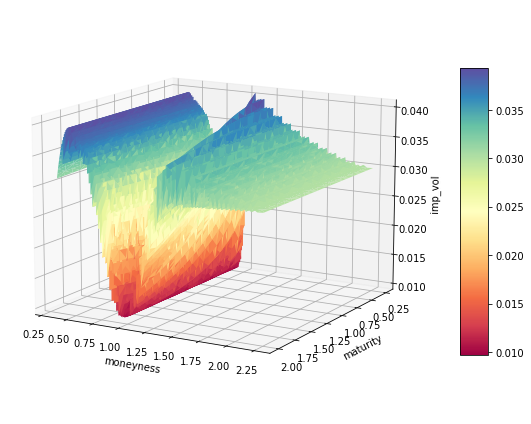

In [237]:
plot_iv_surface(df_iv, z = 'imp_vol')

C:\Users\Jonas\AppData\Local\Temp\ipykernel_14876\1369060011.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


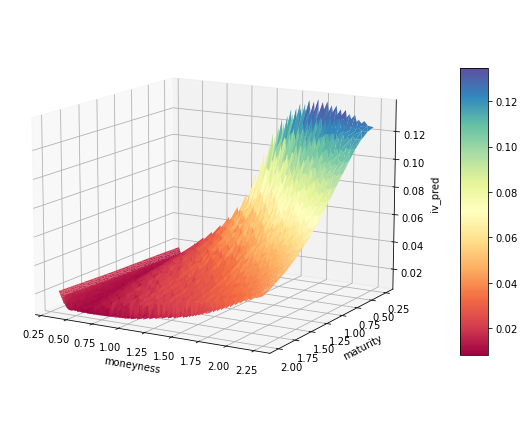

In [238]:
plot_iv_surface(df_iv, z = 'iv_pred')

In [34]:
# Model calibration
from scipy.optimize import minimize, differential_evolution

In [44]:
# Input values for the differential evolution algorithm
target_value = X_test.iat[0,4]
observables = [X_test.iat[0,0], X_test.iat[0,1], X_test.iat[0,2], X_test.iat[0,3]] 
bounds = [-1,1]

# noch per Hand eingetragen

In [47]:
pip install pygad

In [51]:
import pygad
params = pygad.kerasga.model_weights_as_vector(model)

AttributeError: module 'pygad' has no attribute 'kerasga'

In [41]:
# Define the cost function for the differential evolution algorithm
def cost_function(params):
    

In [40]:
X_test

,stock_price,strike_price,maturity,risk_free_rate,sigma
0,0.990842,-0.915673,0.495493,-1.414344,0.654598
1,0.330260,-1.410586,1.321239,-0.000146,-1.091169
2,1.321134,-0.074322,1.156090,-0.707245,-0.654727
3,0.660551,0.420590,-0.165104,-1.414344,0.218157
4,1.155988,0.668047,-1.155999,-0.707245,-0.654727
...,...,...,...,...,...
12343,-0.165177,-1.658042,0.990940,-0.000146,1.527482
12344,-0.000031,-0.519743,1.486388,-1.414344,-1.527611
12345,-0.000031,-1.559060,1.486388,-0.707245,0.218157
12346,-0.495468,1.261942,0.000045,-0.707245,-0.218285


In [39]:
target_value

-1.0911688483531141